In [186]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import matplotlib.cm as cm


In [187]:
# Read the CSV file into a pandas DataFrame
file_path = "data/data.csv"
data = pd.read_csv(file_path)

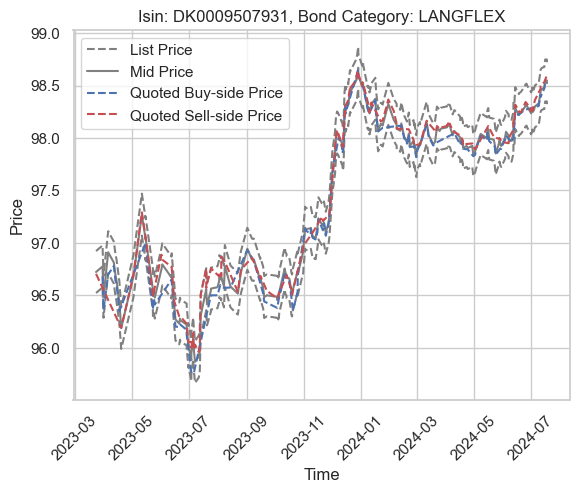

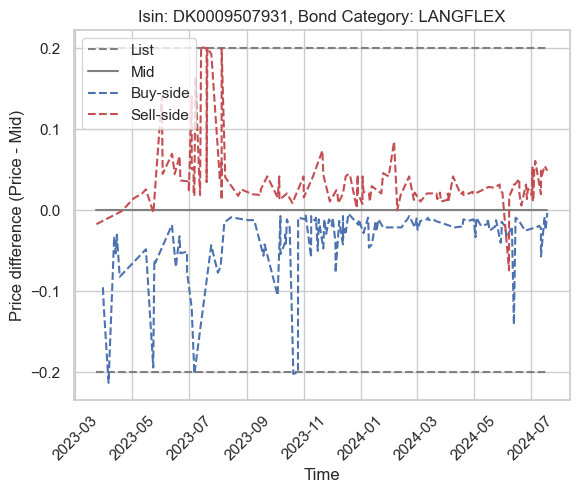

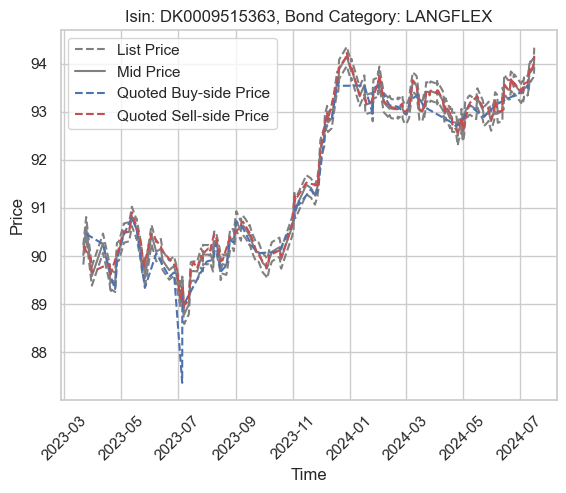

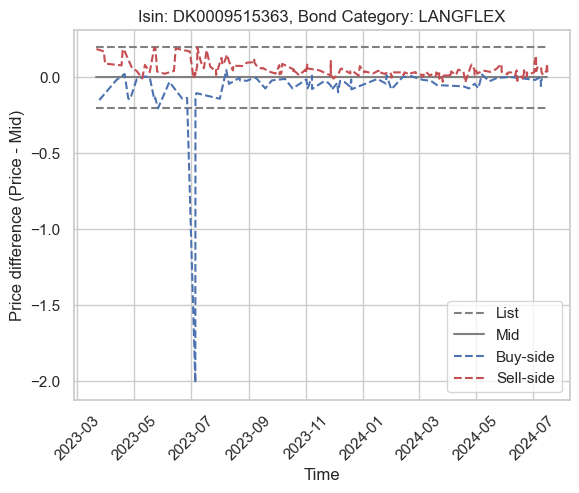

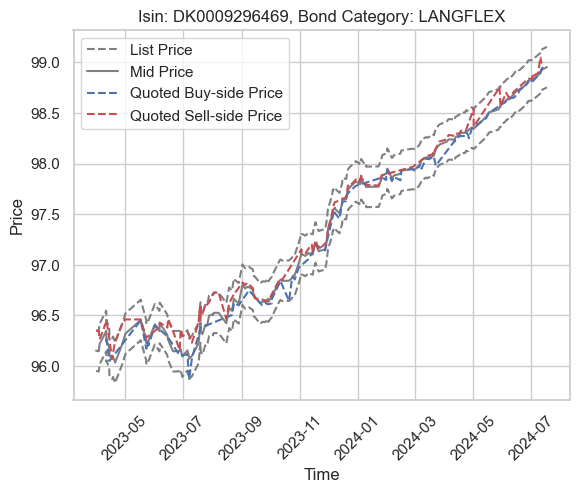

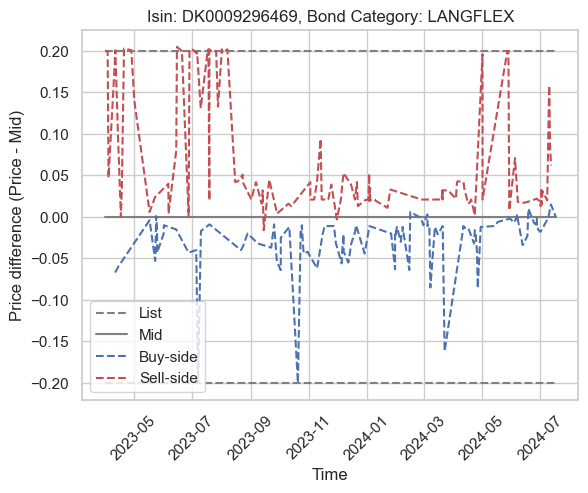

In [188]:
data['TradeTime'] = pd.to_datetime(data['TradeTime'])
data.sort_values(by='TradeTime', inplace=True)
isinCount = data.Isin.value_counts()
plotDic = {}
for i in range(3):
    plotDic[isinCount.index[i]] = data[data.Isin == isinCount.index[i]]
    plotDic[isinCount.index[i]] = (plotDic[isinCount.index[i]]).set_index('TradeTime')

sns.set_theme(style="whitegrid")


for key, df in plotDic.items():
    tit ="Isin: " + key + ", Bond Category: " + str(df.BookName.iloc[0])

    
    plt.plot(df.Bid, color = 'grey', linestyle = '--', label = 'List Price')
    plt.plot(df.Ask, color = 'grey', linestyle = '--')
    plt.plot(df.Mid, color = 'grey', label = 'Mid Price')
    plt.plot(df[df.Side == 'BUY'].Price, color = 'b', linestyle = '--', label = 'Quoted Buy-side Price')
    plt.plot(df[df.Side == 'SELL'].Price, color = 'r', linestyle = '--', label = 'Quoted Sell-side Price')
    plt.ylabel('Price')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(tit)
    #plt.savefig('Figures\priceDevelopment_'+key+'.eps', format = 'eps')
    plt.show()
    
    plt.plot(df.Bid - df.Mid, color = 'grey', linestyle = '--', label = 'List')
    plt.plot(df.Ask - df.Mid, color = 'grey', linestyle = '--')
    plt.plot(df.index, np.zeros(len(df.index)), color = 'grey', label = 'Mid')
    plt.plot(df[df.Side == 'BUY'].Price - df[df.Side == 'BUY'].Mid, color = 'b', linestyle = '--', label = 'Buy-side')
    plt.plot(df[df.Side == 'SELL'].Price - df[df.Side == 'SELL'].Mid, color = 'r', linestyle = '--', label = 'Sell-side')
    plt.ylabel('Price difference (Price - Mid)')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(tit)
    #plt.savefig('Figures\spreadDevelopment_'+key+'.eps', format = 'eps')
    plt.show()

### Dealers in Competition and outcome effect on spread size

C:\Users\JB4846\AppData\Local\Temp\ipykernel_26732\23820464.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y=dep, data = data, palette=palette if palette is not None else 'Blues', fliersize=1)#, showfliers=False)


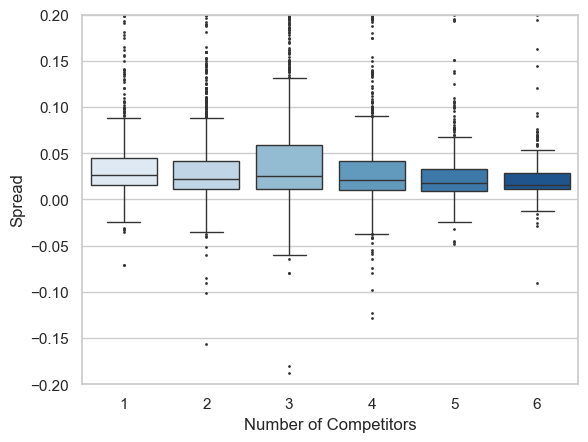

C:\Users\JB4846\AppData\Local\Temp\ipykernel_26732\23820464.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y=dep, data = data, palette=palette if palette is not None else 'Blues', fliersize=1)#, showfliers=False)


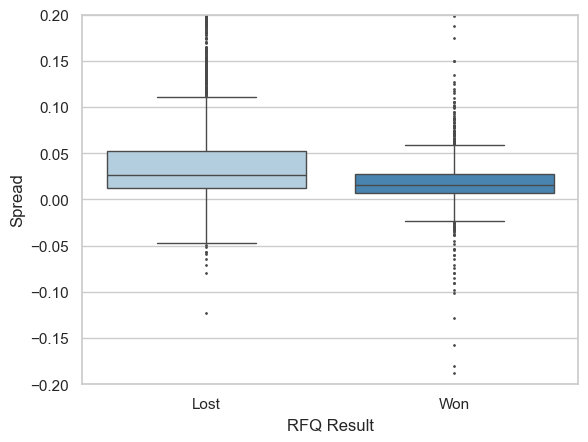

In [189]:
def plot_box_cat(dep, var, df, palette=None):
    data = pd.concat((df[dep], df[var]), axis=1)
    sns.boxplot(x=var, y=dep, data = data, palette=palette if palette is not None else 'Blues', fliersize=1)#, showfliers=False)
    plt.ylim([-0.2,0.2])

def label_spread(row):
    if row.Side == 'BUY':
        spread = row.Mid - row.Price
    if row.Side == 'SELL':
        spread = row.Price - row.Mid
    return spread

data['Spread'] = data.apply(label_spread, axis = 1)

plot_box_cat('Spread', 'DealersInCompetition', data[data.DealersInCompetition < 7])
plt.xlabel('Number of Competitors')
plt.show()

plot_box_cat('Spread', 'Result', data)
plt.xlabel('RFQ Result')
plt.show()



### Time Series plots

C:\Users\JB4846\AppData\Local\Temp\ipykernel_26732\3450382286.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(name='Dark2', lut = number_dealers_of_interest)


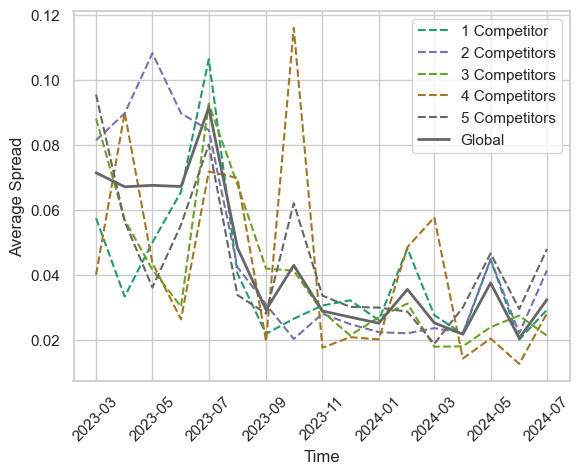

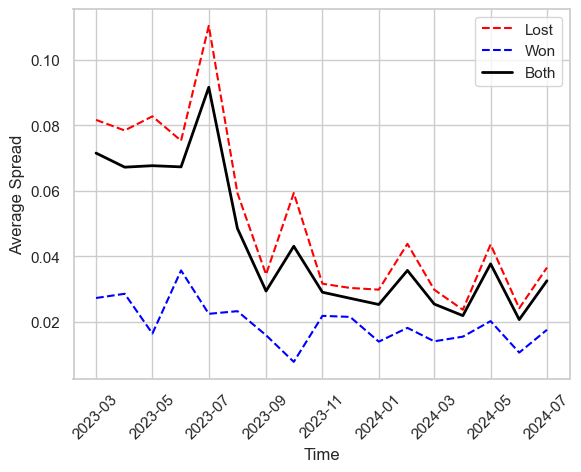

In [190]:
ts_df = data.copy()
ts_df = ts_df.set_index('TradeTime')
ts_df.index = ts_df.index.to_period('M')

number_dealers_of_interest = 5
result_outcomes = 2

globSpreads = []
dealerSpreads = np.zeros((ts_df.index.nunique(), number_dealers_of_interest))
wonLostSpreads = np.zeros((ts_df.index.nunique(),result_outcomes))

for j, date in enumerate(ts_df.index.unique()):
    glob = ts_df.loc[date]
    
    # Calculate average spread for different numbers of competitors
    for i in range(1,number_dealers_of_interest + 1):
        df_subset = glob[glob.DealersInCompetition == i]
        dealerSpreads[j][i-2] = np.mean(df_subset.Spread)
    
    #Calculate average spread for result outcome
    k=0
    for x in df.Result.unique():
        df_subset = glob[glob.Result == x]
        wonLostSpreads[j,k] = np.mean(df_subset.Spread)
        k += 1
    globSpreads.append(np.mean(glob.Spread))

    
byMonth = pd.DataFrame(data = dealerSpreads, columns = ['1 Competitor', '2 Competitors', '3 Competitors', '4 Competitors', '5 Competitors'])
byMonth['Global'] = globSpreads
byMonth.index = pd.to_datetime(ts_df.index.unique().astype(str))

cmap = cm.get_cmap(name='Dark2', lut = number_dealers_of_interest)

for i in range(len(byMonth.columns)-1):
    plt.plot(byMonth.iloc[:,i], color = cmap(i), label = byMonth.columns[i], linestyle = '--')
plt.plot(byMonth.iloc[:,number_dealers_of_interest], color = cmap(number_dealers_of_interest), label = byMonth.columns[number_dealers_of_interest], linewidth = 2)
plt.ylabel('Average Spread')
plt.xlabel('Time')
plt.xticks(rotation=45)
    
plt.legend()
# plt.ylim([-0.2,.3])
#plt.savefig('Figures\TimeSpreadDealers.eps', format = 'eps')
plt.show()

byMonthWL = pd.DataFrame(data = wonLostSpreads, columns = ['Lost', 'Won'])
byMonthWL['Global'] = globSpreads
byMonthWL.index = pd.to_datetime(ts_df.index.unique().astype(str))

plt.plot(byMonthWL.Lost, color = 'red', linestyle = '--', label = 'Lost')
plt.plot(byMonthWL.Won, color = 'blue', linestyle = '--', label = 'Won')
plt.plot(byMonthWL.Global, color = 'black', linewidth = 2, label = 'Both')
plt.ylabel('Average Spread')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.legend()
#plt.savefig('Figures\TimeSpreadWinLoss.eps', format = 'eps')
plt.show()
